In [1]:
# !pip install -r ../exp_requirements.txt

In [2]:
# !pip uninstall virny -y

In [3]:
# Install using an HTTP link
# !pip install git+https://github.com/DataResponsibly/Virny.git@development

# Install using an SSH link
# !pip install git+ssh://git@github.com/DataResponsibly/Virny.git@development

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [6]:
cur_folder_name = os.getcwd().split('/')[-1]
if cur_folder_name != "fairness-variance":
    os.chdir("../..")

print('Current location: ', os.getcwd())

Current location:  /home/denys_herasymuk/UCU/4course_2term/Bachelor_Thesis/Code/fairness-variance


In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from virny.datasets.data_loaders import CompasDataset, ACSIncomeDataset
from source.utils.custom_initializers import create_experiment_data_loader
from source.preprocessing.basic_preprocessing import get_null_imputer_preprocessor

from configs.constants import NUM_METRICS_COMPUTATION_RUNS, EXPERIMENT_SEEDS, TEST_SET_FRACTION

In [8]:
ROOT_DIR = os.path.join(os.getcwd(), "..", "..")

In [9]:
data_loader = CompasDataset()
data_loader.X_data.head()

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,race,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,c_charge_degree_F,c_charge_degree_M,sex
0,25,0.0,-2.340451,1.0,-15.010999,African-American,1,0,0,0,1,1
1,26,0.0,0.000000,0.0,0.000000,Caucasian,1,0,0,1,0,0
2,21,0.0,0.000000,0.0,0.000000,Caucasian,0,0,1,1,0,1
3,29,0.0,0.000000,0.0,6.000000,African-American,1,0,0,0,1,1
4,40,0.0,0.000000,0.0,7.513697,Caucasian,1,0,0,1,0,1


In [10]:
data_loader.full_df.shape

(5278, 13)

In [11]:
data_loader.full_df.isna().sum()

age                        0
juv_fel_count              0
juv_misd_count             0
juv_other_count            0
priors_count               0
age_cat_25 - 45            0
age_cat_Greater than 45    0
age_cat_Less than 25       0
c_charge_degree_F          0
c_charge_degree_M          0
race                       0
sex                        0
recidivism                 0
dtype: int64

In [12]:
def get_column_importances(model, exp_iter_data_loader, column_transformer):
    X_train_val, X_test, y_train_val, y_test = train_test_split(exp_iter_data_loader.X_data, exp_iter_data_loader.y_data,
                                                                test_size=0.1,
                                                                random_state=experiment_seed)
    column_transformer = column_transformer.set_output(transform="pandas")  # Set transformer output to a pandas df
    X_train_features = column_transformer.fit_transform(X_train_val)

    model.fit(X_train_features, y_train_val)
    try:
        importances = pd.DataFrame(data={
            'Attribute': X_train_features.columns,
            'Importance': model.coef_[0]
        })
    except Exception as err:
        importances = pd.DataFrame(data={
            'Attribute': X_train_features.columns,
            'Importance': model.feature_importances_
        })
    return importances.sort_values(by='Importance', ascending=True)

## COMPAS

In [13]:
# Configs for an experiment iteration
exp_iter_num = 1
experiment_seed = EXPERIMENT_SEEDS[exp_iter_num - 1]
# Create a transformed data loader
exp_iter_data_loader = create_experiment_data_loader(data_loader)
preprocessor = get_null_imputer_preprocessor(exp_iter_data_loader)

In [14]:
model = LogisticRegression(C=0.01, max_iter= 50, penalty='l1', solver='liblinear')
importances = get_column_importances(model, exp_iter_data_loader, preprocessor)

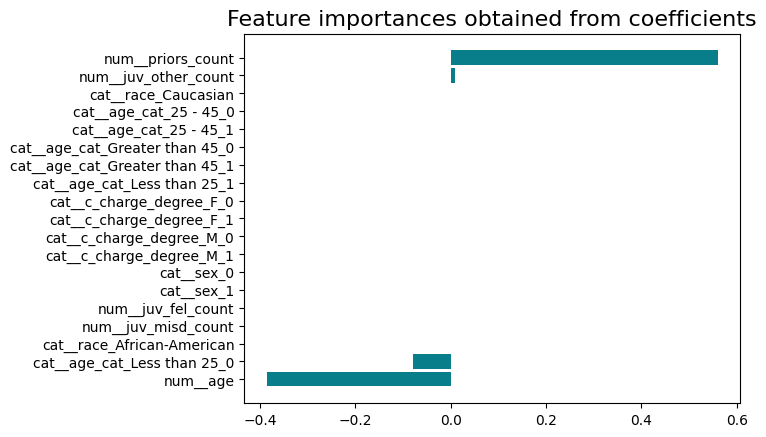

In [15]:
plt.barh(y=importances['Attribute'], width=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=16)
plt.show()

In [16]:
model = RandomForestClassifier(max_depth=6, max_features=0.6, min_samples_leaf=4, n_estimators=50)
importances = get_column_importances(model, exp_iter_data_loader, preprocessor)

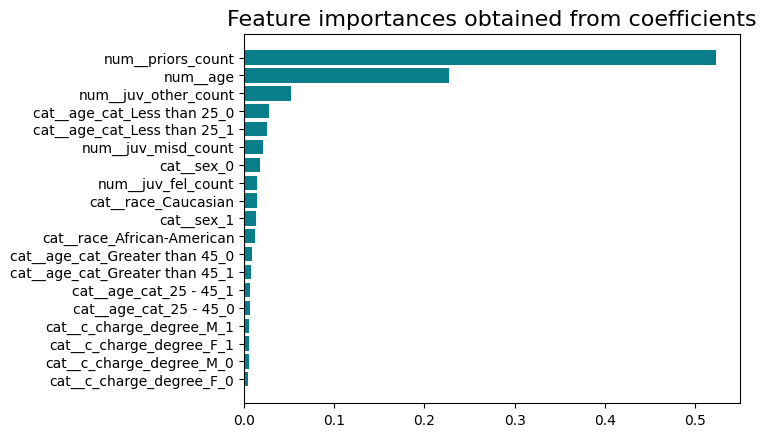

In [17]:
plt.barh(y=importances['Attribute'], width=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=16)
plt.show()

## Folktables Income

In [18]:
data_loader = ACSIncomeDataset(state=['GA'], year=2018, with_nulls=False, subsample_size=20_000, subsample_seed=42)
data_loader.X_data.head()

,SCHL,COW,MAR,OCCP,POBP,RELP,SEX,RAC1P,AGEP,WKHP
0,23,7,3,230,36,0,1,1,55,55.0
1,16,1,5,4110,13,2,2,1,20,35.0
2,16,4,3,4130,51,0,2,1,59,30.0
3,18,4,1,4020,13,0,1,2,43,40.0
4,14,1,1,8300,20,1,2,2,33,20.0


In [19]:
data_loader.full_df.shape

(20000, 10)

In [20]:
data_loader.full_df.isna().sum()

SCHL     0
COW      0
MAR      0
OCCP     0
POBP     0
RELP     0
SEX      0
RAC1P    0
AGEP     0
WKHP     0
dtype: int64

In [21]:
# Configs for an experiment iteration
exp_iter_num = 1
experiment_seed = EXPERIMENT_SEEDS[exp_iter_num - 1]
# Create a transformed data loader
exp_iter_data_loader = create_experiment_data_loader(data_loader)
preprocessor = get_null_imputer_preprocessor(exp_iter_data_loader)

In [22]:
model = LogisticRegression(C=1, max_iter=50, penalty='l2', solver='saga')
importances = get_column_importances(model, exp_iter_data_loader, preprocessor)

In [23]:
importances.head()

,Attribute,Importance
745,cat__RELP_17,-2.081710
512,cat__OCCP_9142,-1.999315
284,cat__OCCP_4600,-1.984345
248,cat__OCCP_4020,-1.969218
222,cat__OCCP_3645,-1.881136


In [24]:
importances2 = importances[(importances['Importance'] > 1) | (importances['Importance'] < -1)].copy(deep=True)

In [25]:
importances2.head()

,Attribute,Importance
745,cat__RELP_17,-2.081710
512,cat__OCCP_9142,-1.999315
284,cat__OCCP_4600,-1.984345
248,cat__OCCP_4020,-1.969218
222,cat__OCCP_3645,-1.881136


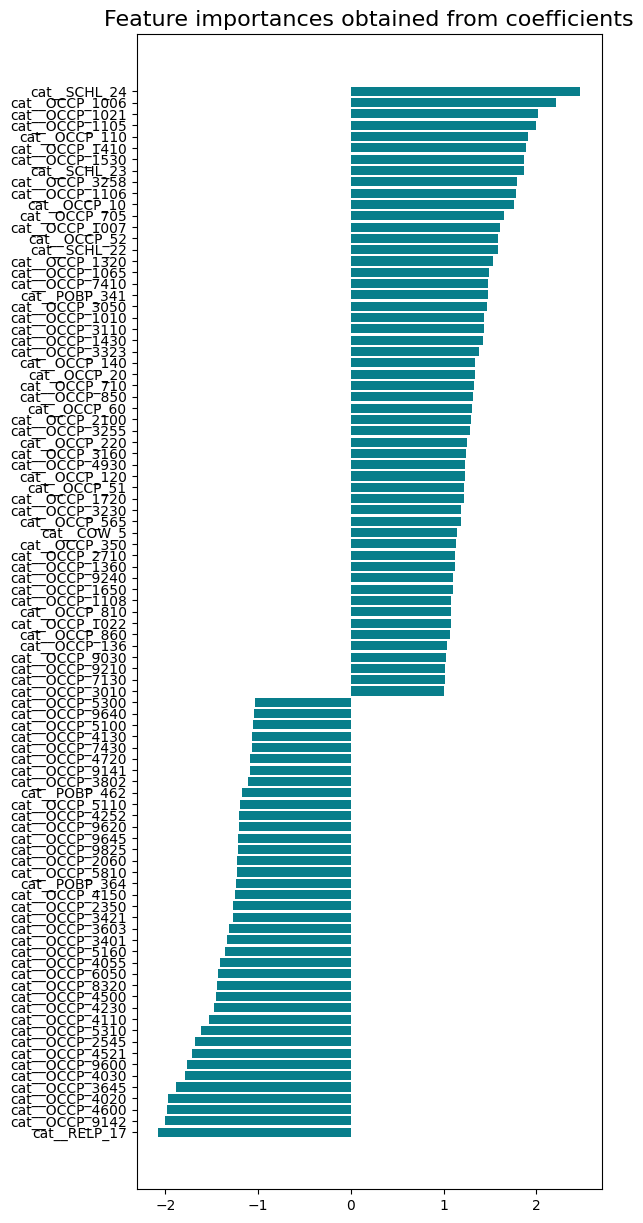

In [26]:
plt.rcParams['figure.figsize'] = [6, 15]
plt.barh(y=importances2['Attribute'], width=importances2['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=16)
plt.show()

In [27]:
model = RandomForestClassifier(max_depth=15, max_features=0.6, min_samples_leaf=6, n_estimators=100)
importances = get_column_importances(model, exp_iter_data_loader, preprocessor)

In [28]:
importances2 = importances[importances['Importance'] > 0.01]

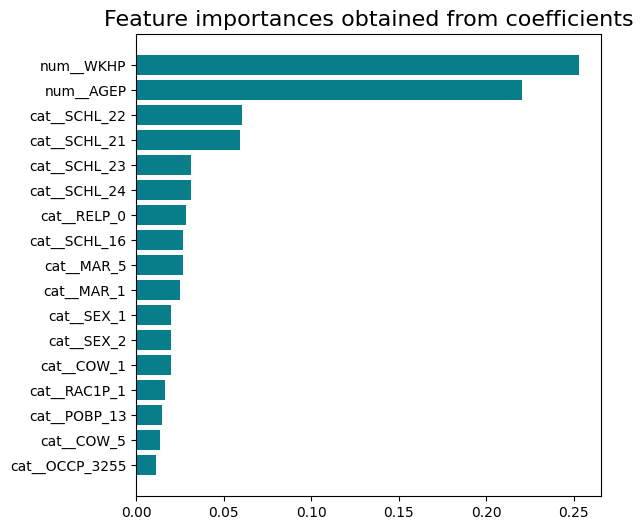

In [31]:
plt.rcParams['figure.figsize'] = [6, 6]
plt.barh(y=importances2['Attribute'], width=importances2['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=16)
plt.show()